In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv(r"C:\Users\Anshula Sridhar\Downloads\archive (4)\fraudTest.csv")

# Check column names to ensure we reference the correct target column
print("Columns in the dataset:")
print(data.columns)

# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# The target column is 'is_fraud' instead of 'Class'
target_column = 'is_fraud'

# Drop non-numeric columns that are not useful for prediction
data = data.drop(columns=['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'])

# Preprocessing: Handle missing values (if any) and normalize features
# Split features and target
X = data.drop(columns=[target_column])  
y = data[target_column]  

# Define preprocessing for numeric features (scaling)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by imputing the mean
    ('scaler', StandardScaler())  # Normalize numeric features
])

# For categorical features (if any)
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine both numeric and categorical transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that first applies preprocessing, then fits the model
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Evaluate each model
for model_name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]  # Probabilities for AUC

    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("Classification Report:")
    print(classification_report(y, y_pred))
    print("AUC Score:", roc_auc_score(y, y_prob))
    print("=" * 50)


Columns in the dataset:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Model: Logistic Regression
Confusion Matrix:
[[553412    162]
 [  2145      0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

AUC Score: 0.8392125139640376
Model: Decision Tree
Confusion Matrix:
[[553574      0]
 [    23   2122]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1

In [10]:
pip install matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


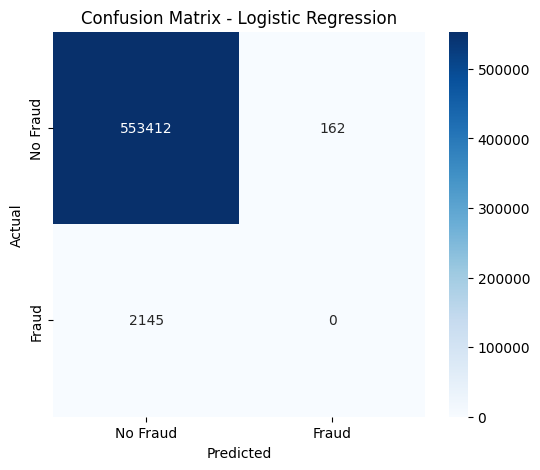

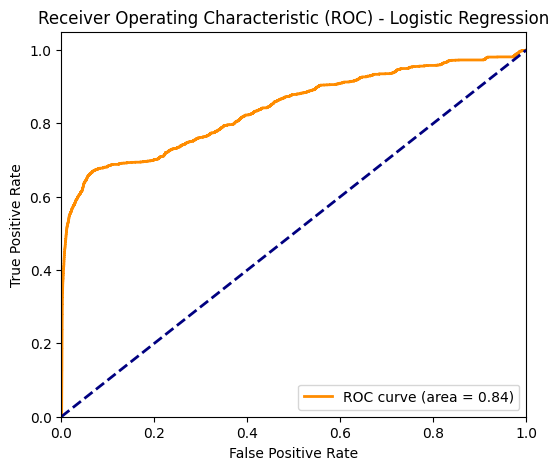

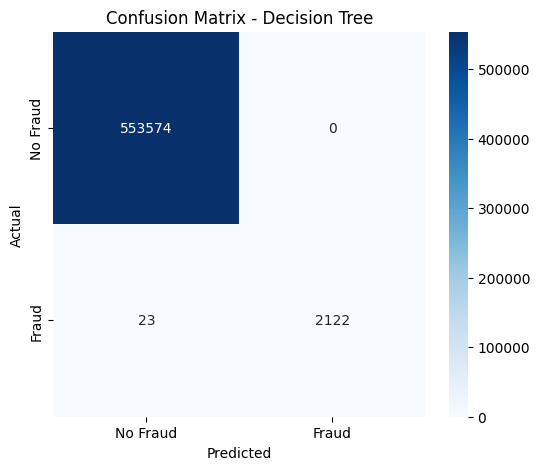

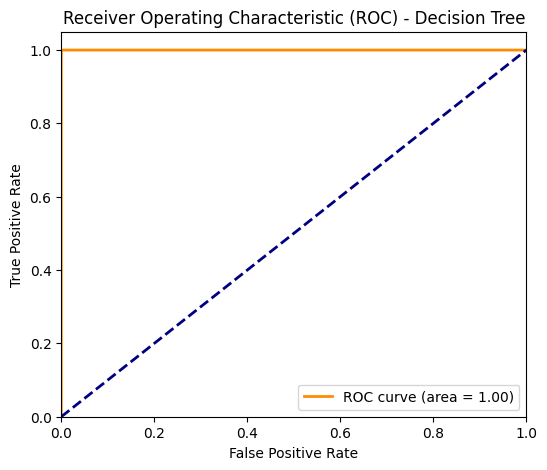

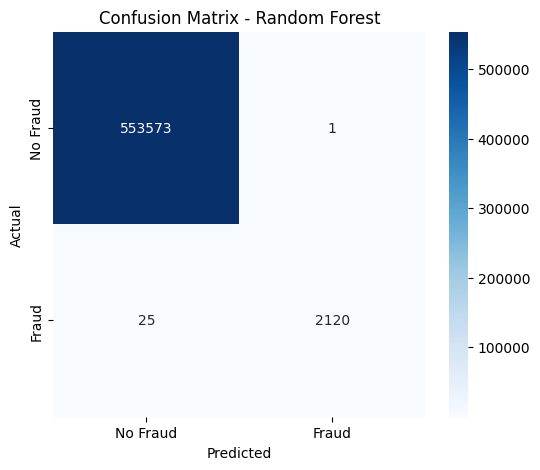

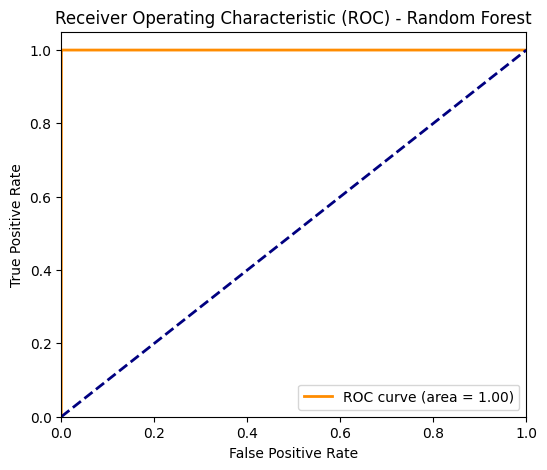

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Define a function to plot the ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot feature importance for tree-based models
def plot_feature_importance(model, X, model_name):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        # Get the feature names after preprocessing
        feature_names = X.columns
        # Handle the one-hot encoding case by mapping feature names correctly
        if hasattr(model, 'named_steps') and 'preprocessor' in model.named_steps:
            # Apply the column transformer to get transformed feature names
            preprocessor = model.named_steps['preprocessor']
            feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(X.select_dtypes(include=['object']).columns)
            feature_names = list(X.select_dtypes(include=['int64', 'float64']).columns) + list(feature_names)
        
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(10, 6))
        plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance - {model_name}')
        plt.show()

# Evaluate and plot results for each model
for model_name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X, y)
    
    # Predict and get probabilities
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]
    
    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot the confusion matrix and ROC curve
    plot_confusion_matrix(cm, model_name)
    plot_roc_curve(fpr, tpr, roc_auc, model_name)
    
    # For tree-based models, plot feature importance
    if model_name in ['Decision Tree', 'Random Forest']:
        plot_feature_importance(clf, X, model_name)
